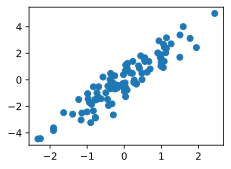

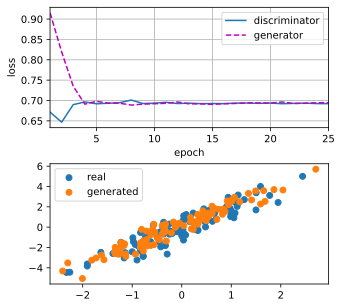

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib

def update_D(batch, Z, net_D, net_G, loss, optimizer_D):
    batch_size = batch.shape[0]
    
    ones = torch.ones(batch_size)
    zeros = torch.zeros(batch_size)
    
    optimizer_D.zero_grad()
    
    real_Y = net_D(batch)
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X.detach())

    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) + loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()

    optimizer_D.step()

    return loss_D

def update_G(Z, net_D, net_G, loss, optimizer_G):
    batch_size = Z.shape[0]

    ones = torch.ones(batch_size)

    optimizer_G.zero_grad()

    fake_X = net_G(Z)
    fake_Y = net_D(fake_X)

    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()

    optimizer_G.step()

    return loss_G


def train(net_D, net_G, lr_D, lr_G, data_iter, num_epochs, dim, data):
    loss = nn.BCEWithLogitsLoss(reduction = 'sum')
    #loss = nn.BCELoss(reduction = 'sum')
     
    #for w in net_D.parameters():
    #    nn.init.normal_(w, 0, 0.02)
    #for w in net_G.parameters():
    #    nn.init.normal_(w, 0, 0.02)


    optimizer_D = torch.optim.SGD(net_D.parameters(), lr = lr_D)
    optimizer_G = torch.optim.SGD(net_G.parameters(), lr = lr_G)

    #optimizer_D = torch.optim.Adam(net_D.parameters(), lr = lr_D)
    #optimizer_G = torch.optim.Adam(net_G.parameters(), lr = lr_G)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        metric = d2l.Accumulator(3)

        for batch in data_iter:
            batch_size = batch.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, dim))
            loss_D = update_D(batch, Z, net_D, net_G, loss, optimizer_D) / batch_size
            loss_G = update_G(Z, net_D, net_G, loss, optimizer_G) /batch_size

        Z = torch.normal(0,1,(100, dim))
        fake_X = net_G(Z).detach().numpy()

        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        animator.add(epoch + 1, (loss_D.detach().numpy(), loss_G.detach().numpy()))



lr_D = 0.05
lr_G = 0.005
dim = 2
num_epochs = 25
size = 1000

X = torch.normal(0.0, 1, (size,dim))
A = torch.tensor([[1,2], [-0.1, 0.5]])
b = torch.tensor([0,0])
data = torch.matmul(X, A) + b

d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100, (1)].detach().numpy());
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

batch_size = 16
data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=True)

net_G = nn.Sequential(
    nn.Linear(2, 2))

net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

train(net_D, net_G, lr_D, lr_G, data_iter, num_epochs, dim, data[:100].detach().numpy())
